*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 15: Classifying Images with Deep Convolutional Neural Networks

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow,tensorflow_datasets

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-10-31 

numpy 1.17.2
scipy 1.2.1
matplotlib 3.1.0
tensorflow 2.0.0
tensorflow_datasets 1.3.0


##  The building blocks of convolutional neural networks

### Understanding CNNs and feature hierarchies

### Performing discrete convolutions

### Discrete convolutions in one dimension

### Padding inputs to control the size of the output feature maps

### Determining the size of the convolution output

In [2]:
import tensorflow as tf
import numpy as np

print('TensorFlow version:', tf.__version__)
print('NumPy version: ', np.__version__)

TensorFlow version: 2.0.0
NumPy version:  1.17.2


In [3]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int(len(x)/s),s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


### Performing a discrete convolution in 2D

In [4]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))


Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Subsampling layers

## Putting everything together – implementing a CNN

### Working with multiple input or color channels



**TIP: Reading an image file**

In [5]:
import tensorflow as tf


img_raw = tf.io.read_file('example-image.png')
img = tf.image.decode_image(img_raw)
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)
print(img[100:102, 100:102, :])

Image shape: (252, 221, 3)
Number of channels: 3
Image data type: <dtype: 'uint8'>
tf.Tensor(
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]], shape=(2, 2, 3), dtype=uint8)


In [6]:
import imageio


img = imageio.imread('example-image.png')
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)
print(img[100:102, 100:102, :])

Image shape: (252, 221, 3)
Number of channels: 3
Image data type: uint8
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]]


**INFO-BOX: The rank of a grayscale image for input to a CNN**

In [7]:
img_raw = tf.io.read_file('example-image-gray.png')
img = tf.image.decode_image(img_raw)
tf.print('Rank:', tf.rank(img))
tf.print('Shape:', img.shape)

Rank: 3
Shape: TensorShape([252, 221, 1])


In [8]:
img = imageio.imread('example-image-gray.png')
tf.print('Rank:', tf.rank(img))
tf.print('Shape:', img.shape)

img_reshaped = tf.reshape(img, (img.shape[0], img.shape[1], 1))
tf.print('New Shape:', img_reshaped.shape)

Rank: 2
Shape: (252, 221)
New Shape: TensorShape([252, 221, 1])


## Regularizing a neural network with dropout



In [9]:
from tensorflow import keras


conv_layer = keras.layers.Conv2D(
    filters=16, kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001))

fc_layer = keras.layers.Dense(
    units=16, kernel_regularizer=keras.regularizers.l2(0.001))

## Loss Functions for Classification

 * **`BinaryCrossentropy()`**
   * `from_logits=False` 
   * `from_logits=True`

 * **`CategoricalCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`
   
 * **`SparseCategoricalCrossentropy()`**
   * `from_logits=False`
   * `from_logits=True`


In [10]:
####### Binary Crossentropy
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)

tf.print(
    'BCE (w Probas): {:.4f}'.format(
    bce_probas(y_true=[1], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    bce_logits(y_true=[1], y_pred=logits)))


####### Categorical Crossentropy
cce_probas = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

tf.print(
    'CCE (w Probas): {:.4f}'.format(
    cce_probas(y_true=[0, 0, 1], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    cce_logits(y_true=[0, 0, 1], y_pred=logits)))

####### Sparse Categorical Crossentropy
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)

tf.print(
    'Sparse CCE (w Probas): {:.4f}'.format(
    sp_cce_probas(y_true=[2], y_pred=probas)),
    '(w Logits): {:.4f}'.format(
    sp_cce_logits(y_true=[2], y_pred=logits)))

BCE (w Probas): 0.3711 (w Logits): 0.3711
CCE (w Probas): 0.5996 (w Logits): 0.5996
Sparse CCE (w Probas): 0.5996 (w Logits): 0.5996


## Implementing a deep convolutional neural network using TensorFlow

### The multilayer CNN architecture

### Loading and preprocessing the data

In [11]:
import tensorflow_datasets as tfds
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
## MNIST dataset

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

dict_keys(['test', 'train'])


In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [14]:
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

### Implementing a CNN using the TensorFlow Keras API

#### Configuring CNN layers in Keras

 * **Conv2D:** `tf.keras.layers.Conv2D`
   * `filters`
   * `kernel_size`
   * `strides`
   * `padding`
   
   
 * **MaxPool2D:** `tf.keras.layers.MaxPool2D`
   * `pool_size`
   * `strides`
   * `padding`
   
   
 * **Dropout** `tf.keras.layers.Dropout2D`
   * `rate`

### Constructing a CNN in Keras

In [15]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))


In [16]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [17]:
    model.add(tf.keras.layers.Flatten())
    
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [18]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

In [19]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 10])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              multiple                  832       
_________________________________________________________________
pool_1 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
conv_2 (Conv2D)              multiple                  51264     
_________________________________________________________________
pool_2 (MaxPooling2D)        multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
fc_1 (Dense)                 multiple                  3212288   
_________________________________________________________________
dropout (Dropout)            multiple                  0

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(mnist_train, epochs=NUM_EPOCHS, 
                    validation_data=mnist_valid, 
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 29s 38ms/step - loss: 0.1450 - accuracy: 0.9549 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
782/782 [==============================] - 27s 34ms/step - loss: 0.0491 - accuracy: 0.9858 - val_loss: 0.0401 - val_accuracy: 0.9874
Epoch 3/20
782/782 [==============================] - 27s 35ms/step - loss: 0.0311 - accuracy: 0.9903 - val_loss: 0.0493 - val_accuracy: 0.9846
Epoch 4/20
782/782 [==============================] - 28s 35ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0489 - val_accuracy: 0.9855
Epoch 5/20
782/782 [==============================] - 27s 35ms/step - loss: 0.0197 - accuracy: 0.9942 - val_loss: 0.0453 - val_accuracy: 0.9874
Epoch 6/20
782/782 [==============================] - 27s 34ms/step - loss: 0.0161 - accuracy: 0.9953 - val_loss: 0.0361 - val_accuracy: 0.9897
Epoch 7/20
782/782 [==============================] - 27s 35ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.0401 - val_a

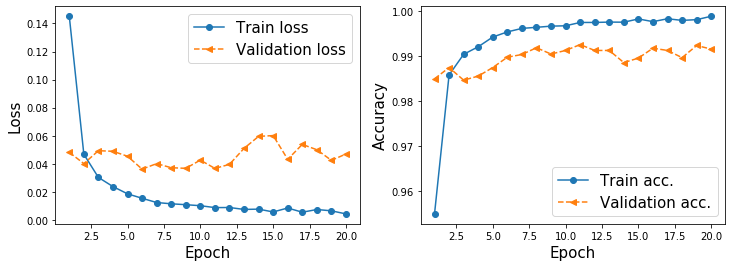

In [22]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figs/B13208-15_12.png', dpi=300)
plt.show()

In [23]:
test_results = model.evaluate(mnist_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

500/500 [==============================] - 3s 5ms/step - loss: 0.0428 - accuracy: 0.9927

Test Acc. 99.27%


TensorShape([12, 10])
tf.Tensor([6 2 3 7 2 2 3 4 7 6 6 9], shape=(12,), dtype=int64)


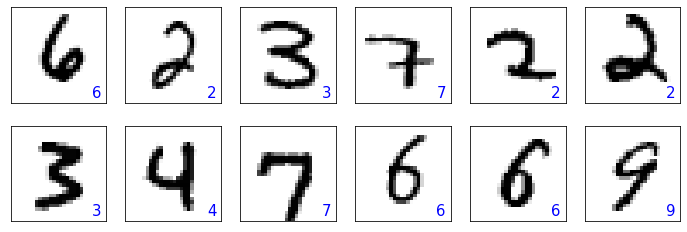

In [24]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figs/B13208-15_13.png', dpi=300)
plt.show()

In [25]:
import os

if not os.path.exists('models'):
    os.mkdir('models')


model.save('models/mnist-cnn.h5')

## Gender classification from face images using CNN


### Loading the CelebA dataset

In [26]:
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)
print(celeba.keys())

celeba_train = celeba['train']
celeba_valid = celeba['validation']
celeba_test = celeba['test']

def count_items(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

print('Train set:  {}'.format(count_items(celeba_train)))
print('Validation: {}'.format(count_items(celeba_valid)))
print('Test set:   {}'.format(count_items(celeba_test)))

dict_keys(['test', 'train', 'validation'])
Train set:  162770
Validation: 19867
Test set:   19962


In [27]:
celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)

print('Train set:  {}'.format(count_items(celeba_train)))
print('Validation: {}'.format(count_items(celeba_valid)))

Train set:  16000
Validation: 1000


### Image transformation and data augmentation

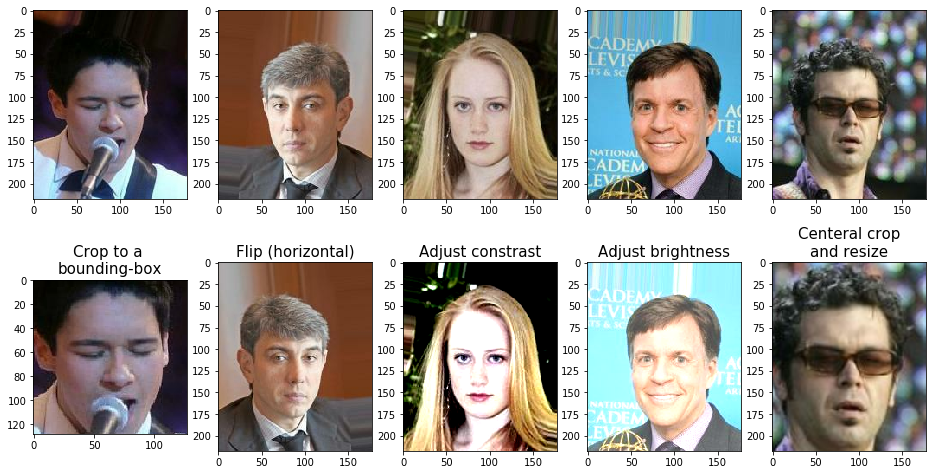

In [28]:
## take 5 examples:
examples = []
for example in celeba_train.take(5):
    examples.append(example['image'])

fig = plt.figure(figsize=(16, 8.5))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
ax.imshow(examples[0])
ax = fig.add_subplot(2, 5, 6)
ax.set_title('Crop to a \nbounding-box', size=15)
img_cropped = tf.image.crop_to_bounding_box(
    examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
ax.imshow(examples[1])
ax = fig.add_subplot(2, 5, 7)
ax.set_title('Flip (horizontal)', size=15)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
ax.imshow(examples[2])
ax = fig.add_subplot(2, 5, 8)
ax.set_title('Adjust constrast', size=15)
img_adj_contrast = tf.image.adjust_contrast(
    examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
ax.imshow(examples[3])
ax = fig.add_subplot(2, 5, 9)
ax.set_title('Adjust brightness', size=15)
img_adj_brightness = tf.image.adjust_brightness(
    examples[3], delta=0.3)
ax.imshow(img_adj_brightness)

## Column 5: cropping from image center 
ax = fig.add_subplot(2, 5, 5)
ax.imshow(examples[4])
ax = fig.add_subplot(2, 5, 10)
ax.set_title('Centeral crop\nand resize', size=15)
img_center_crop = tf.image.central_crop(
    examples[4], 0.7)
img_resized = tf.image.resize(
    img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype('uint8'))

#plt.savefig('figs/B13208-15_14.png', dpi=300)
plt.show()

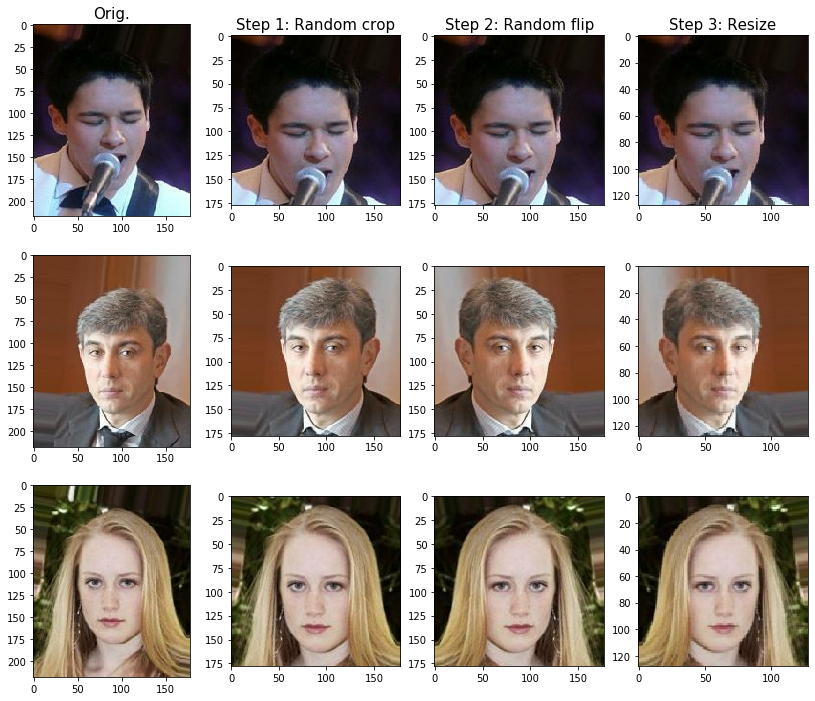

In [29]:
tf.random.set_seed(1)

fig = plt.figure(figsize=(14, 12))

for i,example in enumerate(celeba_train.take(3)):
    image = example['image']

    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(image)
    if i == 0:
        ax.set_title('Orig.', size=15)

    ax = fig.add_subplot(3, 4, i*4+2)
    img_crop = tf.image.random_crop(image, size=(178, 178, 3))
    ax.imshow(img_crop)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = tf.image.random_flip_left_right(img_crop)
    ax.imshow(tf.cast(img_flip, tf.uint8))
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resize = tf.image.resize(img_flip, size=(128, 128))
    ax.imshow(tf.cast(img_resize, tf.uint8))
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)

#plt.savefig('figs/B13208-15_15.png', dpi=300)
plt.show()

In [30]:
def preprocess(example, size=(64, 64), mode='train'):
    image = example['image']
    label = example['attributes']['Male']
    if mode == 'train':
        image_cropped = tf.image.random_crop(
            image, size=(178, 178, 3))
        image_resized = tf.image.resize(
            image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(
            image_resized)
        return (image_flip/255.0, tf.cast(label, tf.int32))
    
    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0,
            target_height=178, target_width=178)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

## testing:
#item = next(iter(celeba_train))
#preprocess(item, mode='train')

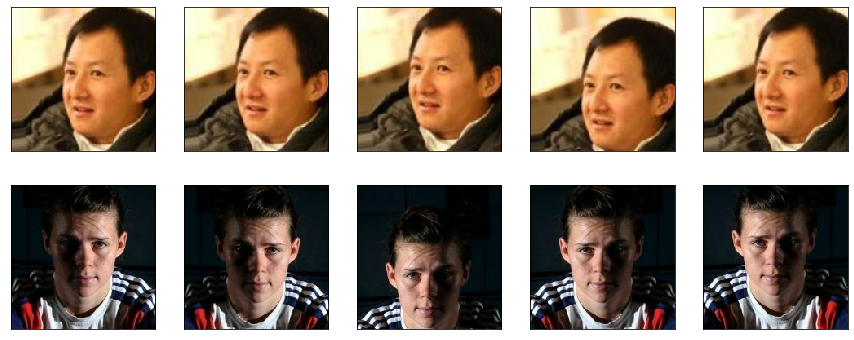

In [31]:
tf.random.set_seed(1)

ds = celeba_train.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(2).repeat(5)

ds = ds.map(lambda x:preprocess(x, size=(178, 178), mode='train'))

fig = plt.figure(figsize=(15, 6))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j//2+(j%2)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    
#plt.savefig('figs/B13208-15_16.png', dpi=300)
plt.show()

In [32]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(16000/BATCH_SIZE)
print(steps_per_epoch)

ds_train = celeba_train.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = celeba_valid.map(
    lambda x: preprocess(x, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

500.0


### Training a CNN gender classifier

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(
        256, (3, 3), padding='same', activation='relu'),
])

In [34]:
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 8, 8, 256])

In [35]:
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.compute_output_shape(input_shape=(None, 64, 64, 3))


TensorShape([None, 256])

In [36]:
model.add(tf.keras.layers.Dense(1, activation=None))

In [37]:
tf.random.set_seed(1)

model.build(input_shape=(None, 64, 64, 3))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            multiple                  896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                 

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=20, steps_per_epoch=steps_per_epoch)


Train for 500.0 steps
Epoch 1/20
500/500 [==============================] - 30s 60ms/step - loss: 0.6232 - accuracy: 0.6235 - val_loss: 0.5808 - val_accuracy: 0.7320
Epoch 2/20
500/32 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 26s 52ms/step - loss: 0.4629 - accuracy: 0.7109 - val_loss: 0.4583 - val_accuracy: 0.7850
Epoch 3/20
500/32 [==========================================================================================================================================================================================================================================

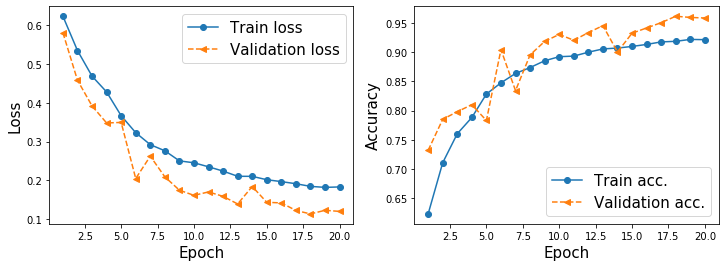

In [39]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figs/B13208-15_18.png', dpi=300)
plt.show()

In [40]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1]*100))

Test Acc: 94.63%


In [41]:
history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=30, initial_epoch=20,
                    steps_per_epoch=steps_per_epoch)

Train for 500.0 steps
Epoch 21/30
500/500 [==============================] - 27s 54ms/step - loss: 0.1741 - accuracy: 0.9249 - val_loss: 0.1222 - val_accuracy: 0.9460
Epoch 22/30
500/32 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 26s 52ms/step - loss: 0.2248 - accuracy: 0.9246 - val_loss: 0.1197 - val_accuracy: 0.9530
Epoch 23/30
500/32 [=======================================================================================================================================================================================================================================

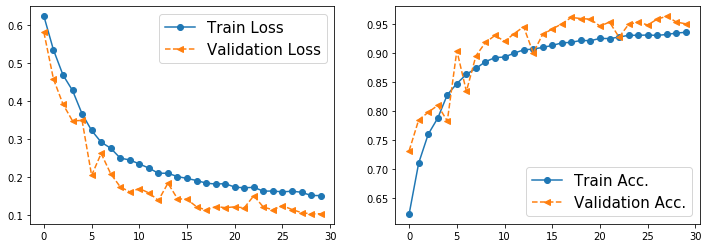

In [42]:
hist2 = history.history
x_arr = np.arange(len(hist['loss'] + hist2['loss']))


fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss']+hist2['loss'], 
        '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss']+hist2['val_loss'],
        '--<', label='Validation Loss')
ax.legend(fontsize=15)


ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy']+hist2['accuracy'], 
        '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy']+hist2['val_accuracy'], 
        '--<', label='Validation Acc.')
ax.legend(fontsize=15)
plt.show()

In [43]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1]*100))

Test Acc: 95.07%


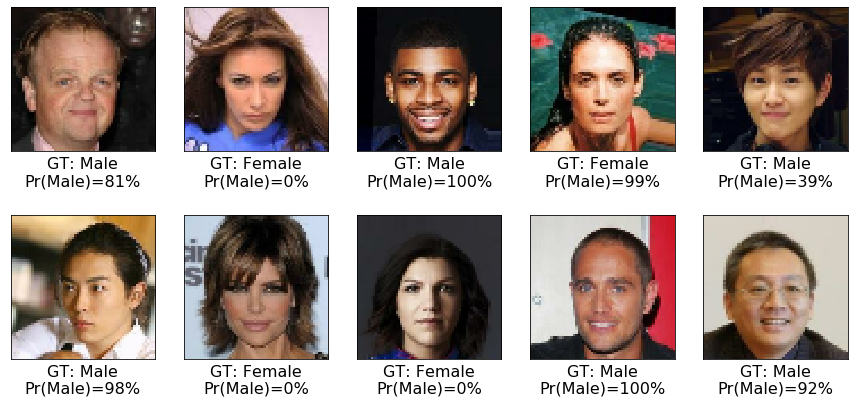

In [44]:
ds = ds_test.unbatch().take(10)

pred_logits = model.predict(ds.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

fig = plt.figure(figsize=(15, 7))
for j,example in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label='Male'
    else:
        label = 'Female'
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(Male)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
#plt.savefig('figs/B13208-15_19.png', dpi=300)
plt.show()

In [45]:
model.save('models/celeba-cnn.h5')

...


## Summary

...



## Appendix:

### The effect of initial shuffling

In [46]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd


## MNIST dataset
#datasets = tfds.load(name='mnist')
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']


mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=10000,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(100)#.batch(BATCH_SIZE)
mnist_train = mnist_train.skip(100)#.batch(BATCH_SIZE)

**Notice that count-of-labels in mnist_valid did not stay the same when the dataset is loaded with using Builder and specifying `mnist_bldr.as_dataset(shuffle_files=False)`**

In [47]:
from collections import Counter

def count_labels(ds):
    counter = Counter()
    for example in ds:
        counter.update([example[1].numpy()])
    return counter
    
print('Count of labels:  ', count_labels(mnist_valid))
print('Count of labels:  ', count_labels(mnist_valid))

Count of labels:   Counter({1: 13, 0: 13, 9: 12, 4: 11, 5: 11, 2: 10, 6: 9, 7: 8, 3: 7, 8: 6})
Count of labels:   Counter({1: 13, 0: 13, 9: 12, 4: 11, 5: 11, 2: 10, 6: 9, 7: 8, 3: 7, 8: 6})


In [48]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd


## MNIST dataset
datasets = tfds.load(name='mnist')
#mnist_bldr = tfds.builder('mnist')
#mnist_bldr.download_and_prepare()
#datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']


mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=10000,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(100)#.batch(BATCH_SIZE)
mnist_train = mnist_train.skip(100)#.batch(BATCH_SIZE)



**Notice that count-of-labels in mnist_valid did not stay the same when the dataset is loaded with `tfds.load()`**

In [49]:
from collections import Counter

def count_labels(ds):
    counter = Counter()
    for example in ds:
        counter.update([example[1].numpy()])
    return counter
    
print('Count of labels:  ', count_labels(mnist_valid))
print('Count of labels:  ', count_labels(mnist_valid))

Count of labels:   Counter({1: 13, 0: 13, 9: 12, 4: 11, 5: 11, 2: 10, 6: 9, 7: 8, 3: 7, 8: 6})
Count of labels:   Counter({1: 13, 0: 13, 9: 12, 4: 11, 5: 11, 2: 10, 6: 9, 7: 8, 3: 7, 8: 6})


----

Readers may ignore the next cell.

In [50]:
! python ../.convert_notebook_to_script.py --input ch15-notebook.ipynb --output ch15.py

[NbConvertApp] Converting notebook ch15-notebook.ipynb to script
[NbConvertApp] Writing 22676 bytes to ch15.py
